In [1]:
import numpy as np
import os, cv2, random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import train_test_split
import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn.cross_validation import  cross_val_score

from skimage.feature import greycomatrix, greycoprops
from skimage.feature import hog

In [2]:
# processamento
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%250 == 0: print('Processed {} of {}'.format(i, count))    
    return data

def prep_data_image(images):
    count = len(images)
    data = np.ndarray((count, COLS, ROWS, CHANNELS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image
        if i%250 == 0: print('Processed {} of {}'.format(i, count))    
    return data

def show_cats_and_dogs(idx):
    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
# descritores
def image_to_feature_vector(image, size=(32, 32)):
    # resize the image to a fixed size, then flatten the image into
    # a list of raw pixel intensities
    return cv2.resize(image, size).flatten()

def extract_color_histogram(image, bins=(8, 8, 8)):     
    # extract a 3D color histogram from the HSV color space using
    # the supplied number of `bins` per channel
    #image = cv2.imread(image_file)        
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
        [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)

    # return the flattened histogram as the feature vector
    return hist.flatten()

In [3]:
TRAIN_DIR = 'train/'

ROWS = 128
COLS = 128
CHANNELS = 3
NIM = 4625

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] #full dataset: dogs and cats
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

# slice datasets for memory efficiency: delete if using full dataset
train_images = train_dogs[:NIM] + train_cats[:NIM]
random.shuffle(train_images)

# read the images
train = prep_data(train_images)
print("Train shape: {}".format(train.shape))

# create the label array
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)


Processed 0 of 9250
Processed 250 of 9250
Processed 500 of 9250
Processed 750 of 9250
Processed 1000 of 9250
Processed 1250 of 9250
Processed 1500 of 9250
Processed 1750 of 9250
Processed 2000 of 9250
Processed 2250 of 9250
Processed 2500 of 9250
Processed 2750 of 9250
Processed 3000 of 9250
Processed 3250 of 9250
Processed 3500 of 9250
Processed 3750 of 9250
Processed 4000 of 9250
Processed 4250 of 9250
Processed 4500 of 9250
Processed 4750 of 9250
Processed 5000 of 9250
Processed 5250 of 9250
Processed 5500 of 9250
Processed 5750 of 9250
Processed 6000 of 9250
Processed 6250 of 9250
Processed 6500 of 9250
Processed 6750 of 9250
Processed 7000 of 9250
Processed 7250 of 9250
Processed 7500 of 9250
Processed 7750 of 9250
Processed 8000 of 9250
Processed 8250 of 9250
Processed 8500 of 9250
Processed 8750 of 9250
Processed 9000 of 9250
Train shape: (9250L, 3L, 128L, 128L)


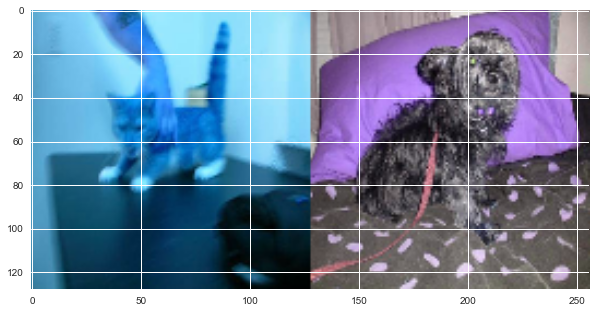

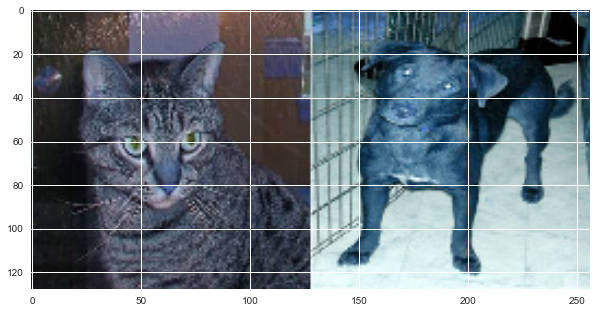

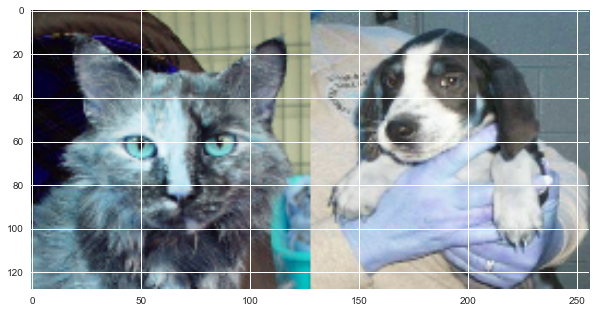

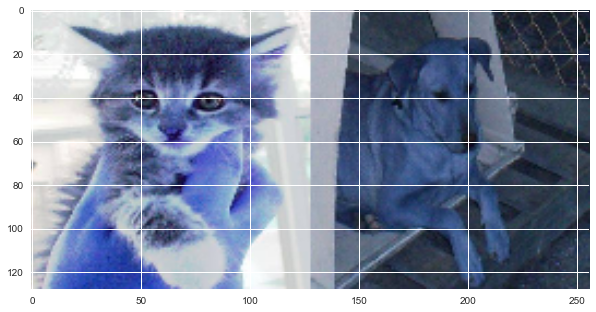

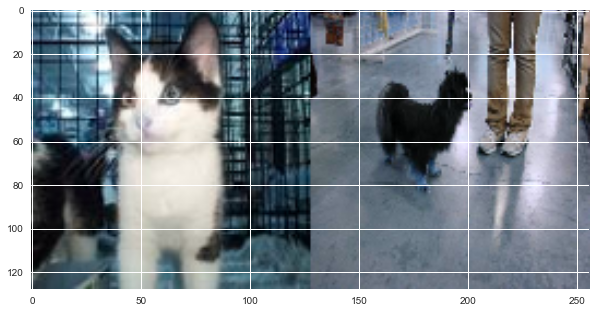

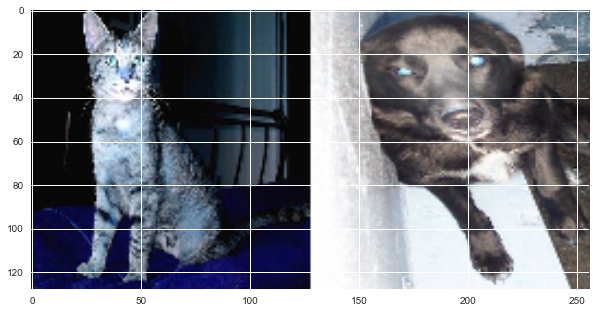

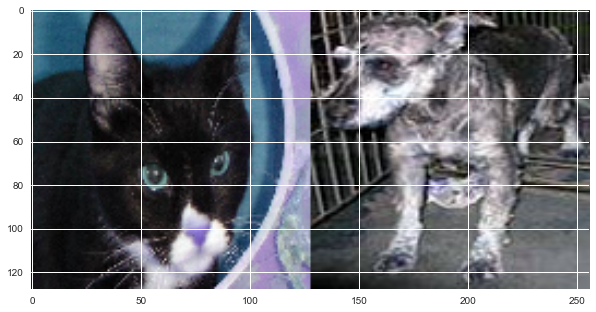

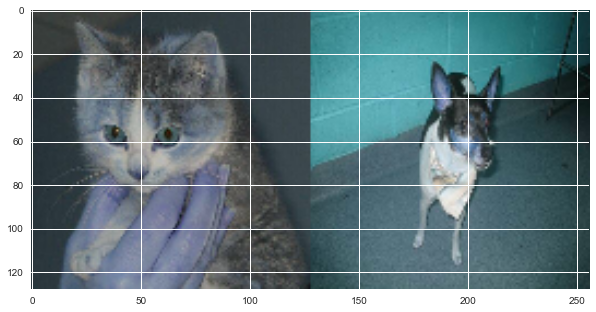

In [4]:
for idx in range(0,8):
    show_cats_and_dogs(idx)

In [5]:
rawImages = []
descHist = []

count = len(train_images)

for i, image_file in enumerate(train_images):
    image = read_image(image_file)
    pixels = image_to_feature_vector(image)
    histogram = extract_color_histogram(image)
    
    rawImages.append(pixels)
    descHist.append(histogram)
        
    if i%250 == 0: print('Processed {} of {}'.format(i, count))

Processed 0 of 9250
Processed 250 of 9250
Processed 500 of 9250
Processed 750 of 9250
Processed 1000 of 9250
Processed 1250 of 9250
Processed 1500 of 9250
Processed 1750 of 9250
Processed 2000 of 9250
Processed 2250 of 9250
Processed 2500 of 9250
Processed 2750 of 9250
Processed 3000 of 9250
Processed 3250 of 9250
Processed 3500 of 9250
Processed 3750 of 9250
Processed 4000 of 9250
Processed 4250 of 9250
Processed 4500 of 9250
Processed 4750 of 9250
Processed 5000 of 9250
Processed 5250 of 9250
Processed 5500 of 9250
Processed 5750 of 9250
Processed 6000 of 9250
Processed 6250 of 9250
Processed 6500 of 9250
Processed 6750 of 9250
Processed 7000 of 9250
Processed 7250 of 9250
Processed 7500 of 9250
Processed 7750 of 9250
Processed 8000 of 9250
Processed 8250 of 9250
Processed 8500 of 9250
Processed 8750 of 9250
Processed 9000 of 9250


In [6]:
# HOG

imgs = prep_data_image(train_images)
sifts = []
hogs = []

for img in imgs:
    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT()
    kp, dc = sift.detectAndCompute(gray,None)
    sifts.append(dc);
    
    hog = cv2.HOGDescriptor()
    h = hog.compute(gray)
    hogs.append(h)

hogs = np.resize(hogs, (len(hogs), len(hogs[0])))

(X_train, X_test, y_train, y_test) = train_test_split(
    np.array(hogs), labels, test_size=0.25, random_state=42)

# variáveis otimizadas experimentalmente
classifiers = [
    KNeighborsClassifier(), # é ruim para HOG
    DecisionTreeClassifier(max_depth = 50),
    GaussianNB()]

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = clf.score(X_test, y_test)
    print("accuracy: {:.2f}%".format(acc * 100)) 

Processed 0 of 9250
Processed 250 of 9250
Processed 500 of 9250
Processed 750 of 9250
Processed 1000 of 9250
Processed 1250 of 9250
Processed 1500 of 9250
Processed 1750 of 9250
Processed 2000 of 9250
Processed 2250 of 9250
Processed 2500 of 9250
Processed 2750 of 9250
Processed 3000 of 9250
Processed 3250 of 9250
Processed 3500 of 9250
Processed 3750 of 9250
Processed 4000 of 9250
Processed 4250 of 9250
Processed 4500 of 9250
Processed 4750 of 9250
Processed 5000 of 9250
Processed 5250 of 9250
Processed 5500 of 9250
Processed 5750 of 9250
Processed 6000 of 9250
Processed 6250 of 9250
Processed 6500 of 9250
Processed 6750 of 9250
Processed 7000 of 9250
Processed 7250 of 9250
Processed 7500 of 9250
Processed 7750 of 9250
Processed 8000 of 9250
Processed 8250 of 9250
Processed 8500 of 9250
Processed 8750 of 9250
Processed 9000 of 9250
KNeighborsClassifier
****Results****
accuracy: 54.99%
DecisionTreeClassifier
****Results****
accuracy: 58.71%
GaussianNB
****Results****
accuracy: 69.61%


In [8]:
# vetor de características com as intensidades de cada pixel
(X_train, X_test, y_train, y_test) = train_test_split(
    rawImages, labels, test_size=0.25, random_state=42)

# variáveis otimizadas experimentalmente
classifiers = [
    KNeighborsClassifier(n_neighbors = 185, weights = 'distance'),
    DecisionTreeClassifier(max_depth = 100),
    GaussianNB()]

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = clf.score(X_test, y_test)
    print("accuracy: {:.2f}%".format(acc * 100))    

KNeighborsClassifier
****Results****
accuracy: 59.58%
DecisionTreeClassifier
****Results****
accuracy: 54.91%
GaussianNB
****Results****
accuracy: 57.28%


In [9]:
# histograma de cores no espaço HSV

(X_train, X_test, y_train, y_test) = train_test_split(
    descHist, labels, test_size=0.25, random_state=42)

# variáveis otimizadas experimentalmente
classifiers = [
    KNeighborsClassifier(n_neighbors = 1390, weights = 'distance'),    
    DecisionTreeClassifier(max_depth = 1000),
    GaussianNB()]

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = clf.score(X_test, y_test)
    print("accuracy: {:.2f}%".format(acc * 100))   

KNeighborsClassifier
****Results****
accuracy: 60.83%
DecisionTreeClassifier
****Results****
accuracy: 58.45%
GaussianNB
****Results****
accuracy: 57.50%


In [10]:
# combinações entre todos esses descritores

trainAux = np.hstack((descHist, rawImages, hogs))
(X_train, X_test, y_train, y_test) = train_test_split(
    trainAux, labels, test_size=0.25, random_state=42)

classifiers = [
    KNeighborsClassifier(n_neighbors = 340, weights = 'distance'),
    DecisionTreeClassifier(max_depth = 100),
    GaussianNB()]

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = clf.score(X_test, y_test)
    print("accuracy: {:.2f}%".format(acc * 100))   

KNeighborsClassifier
****Results****
accuracy: 58.32%
DecisionTreeClassifier
****Results****
accuracy: 59.79%
GaussianNB
****Results****
accuracy: 69.48%
